# ADM-HW5: GROUP #10

#### Xavier Del Giudice, 


|      STUDENT       |   ID    |                 E-mail                  |
|:------------------:|:-------:|:---------------------------------------:|
| Xavier Del Giudice | 1967219 | delgiudice.1967219@studenti.uniroma1.it |
|  Flavio Mangione   |  |      |
|     Leo Rocci      |  |       |
|       |  |      |

## Import and Install required packages

In [1]:
%pip install pandas numpy scikit-learn matplotlib pyspark plotly kagglehub geopy networkx

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import os
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import numpy as np
import kagglehub
import networkx as nx
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import folium
from folium.plugins import MarkerCluster
import geopandas as gpd
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut, GeocoderUnavailable
import time
import plotly.express as px
import plotly.graph_objects as go

## Import the dataset

## 1. Flight Network Analysis (Q1)

In [2]:
df = pd.read_csv('final_df.csv')

First of all we need to create our graph. We decided to create an oriented graph because most of the routes has its own reverse, overall there are more routes with the reverse path than not.

In [3]:
# Initialize an oriented graph
graph = nx.DiGraph()

# Add edges to the graph aggregating the routes with same origin and destination
for index, row in df.iterrows():
    origin = row['Origin_airport']
    destination = row['Destination_airport']
    passengers = row['Passengers']
    distance = row['Distance']
    origin_city = row['Origin_city']
    destination_city = row['Destination_city']
    origin_population = row['Origin_population']
    destination_population = row['Destination_population']
    origin_lat = row['Org_airport_lat']
    origin_long = row['Org_airport_long']
    dest_lat = row['Dest_airport_lat']
    dest_long = row['Dest_airport_long']
    
    # Add attributes to the nodes, in this way we can use the graph to compute summaries instead of the DataFrame
    if not graph.has_node(origin):
        graph.add_node(origin, 
                       city=origin_city, 
                       population=origin_population, 
                       latitude=origin_lat, 
                       longitude=origin_long)
    
    if not graph.has_node(destination):
        graph.add_node(destination, 
                       city=destination_city, 
                       population=destination_population, 
                       latitude=dest_lat, 
                       longitude=dest_long)
    
    # If the edge has been collected yet, add the passengers to it
    # in this way we are storing the total number of passengers for each route
    if graph.has_edge(origin, destination):
        graph[origin][destination]['passengers'] += passengers
    else:
        # Otherwise, add the new edge considering as a weight the distance between the nodes
        graph.add_edge(origin, destination, weight=distance, passengers=passengers)

# 2. Nodes' Contribution  (Q2)

**In any network, certain nodes (such as airports) play a critical role in maintaining connectivity and flow. Centrality measures are used to identify these important nodes.** 

In this section, we will implement four centrality measures for a given airport:

### **Betweenness Centrality**
Betweenness centrality measures how often a node appears on the shortest paths between other nodes.

**Formula:**


$C_B(v) = \sum_{s \neq v \neq t \in T } \frac{\sigma_{st}(v)}{\sigma_{st}}$


Where:
- **$C_B(v)$** is the betweenness centrality of node \( v \).
- **$sigma_{st}$** is the total number of shortest paths between nodes \( s \) and \( t \).
- **$sigma_{st}(v)$** is the number of shortest paths between nodes \( s \) and \( t \) that pass through node \( v \).

---

### **Closeness Centrality**
Closeness centrality measures how easily a node can access all other nodes in the network, essentially reflecting the average distance from the node to all other nodes.

**Formula:**


$C_C(v) = \frac{n-1}{\sum_{v \neq u} d(v, u)}$


Where:
- **$ C_C(v) $** is the closeness centrality of node \( v \).
- **$ n $** is the total number of nodes (airports) in the network.
- **$ d(v, u) $** is the shortest distance between nodes \( v \) and \( u \).

---

### **Degree Centrality**
Degree centrality measures the number of direct connections a node has to other nodes. In the case of airports, it counts the number of direct flights to other airports.

**Formula:**


$C_D(v) = \frac{deg(v)}{n - 1}$


Where:
- **$ C_D(v) $** is the degree centrality of node \( v \).
- **$ deg(v) $** is the degree of node \( v \), in this case the number of direct connections (flights) it has to other nodes (airports).
- **$ n $** is the total number of nodes (airports) in the network.

---

### **PageRank**
PageRank computes the "importance" of a node based on the incoming connections it receives and the weights of those connections.

**Formula:**


$PR(v) = \frac{1 - p}{n} + p \sum_{u \in M(v)} \frac{PR(u)}{L(u)}$


Where:
- **$ PR(v) $** is the PageRank of node \( v \).
- **$ p $** is the damping factor (typically set to 0.85), representing the probability that a random surfer will continue following links instead of jumping to a random node.
- **$ n $** is the total number of nodes (airports) in the network.
- **$ M(v) $** is the set of nodes that link to node \( v \).
- **$ PR(u) $** is the PageRank of node \( u \), which represents the importance of airport \( u \).
- **$ L(u) $** is the number of outbound links from node \( u \), in this case the number of direct flights from airport \( u \).


## 2.1 Analyze Centrality

For this section, to compute the following centrality measures we have defined a class named **GraphMetrics**. This class take as input a network graph (in this case directed graph) and compute this measures. We can find more details with `help` function of Python below. 

In [4]:
from Network_Metrics import GraphMetrics
help(GraphMetrics)

Help on class GraphMetrics in module Network_Metrics:

class GraphMetrics(builtins.object)
 |  GraphMetrics(graph)
 |  
 |  The GraphMetrics class provides various methods to analyze centrality measures in a directed graph using NetworkX. 
 |  It includes functions to compute betweenness centrality, closeness centrality, degree centrality, PageRank, and Katz centrality. 
 |  The class uses Dijkstra's algorithm to calculate shortest paths for centrality calculations. 
 |  It also provides a method, analyze_centrality, that returns a DataFrame summarizing these centrality scores for a given node (airport).
 |  
 |  Methods defined here:
 |  
 |  __init__(self, graph)
 |      Initialize the network analyzer with a graph representation.
 |      
 |      Args:
 |          graph --> nx.DiGraph(): Directed Graph from Networkx Library
 |  
 |  analyze_centrality(self, airport: str)
 |      Comprehensive centrality analysis for a specific node.
 |      This function compute the following centra

In [5]:
G=GraphMetrics(graph) # Initialize the Graph Metrics class taking the previously created graph as input

We use the class's `analyze_centrality` function to calculate all the centrality measures for the airport we give as input

In [7]:
import random
airport=random.choice(list(G.nodes)) # Choose a random airoport from list of all nodes (airports) of the graph
centrality=G.analyze_centrality(airport) # Store the results of the function in centrality variable
centrality # Show the results 

,Airport,Betweenness Centrality,Closeness Centrality,Degree Centrality,PageRank Score
0,GUP,0.002367,0.000862,0.013774,0.00044


## 2.2 Compare Centralities

1. In this section we compute and compare centrality values for all nodes in the graph with `compare_centralities(graph)` of **Centrality_Graph** module;
2. Plot centrality distributions (histograms for each centrality measure);
3. Return the top 5 airports for each centrality measure.

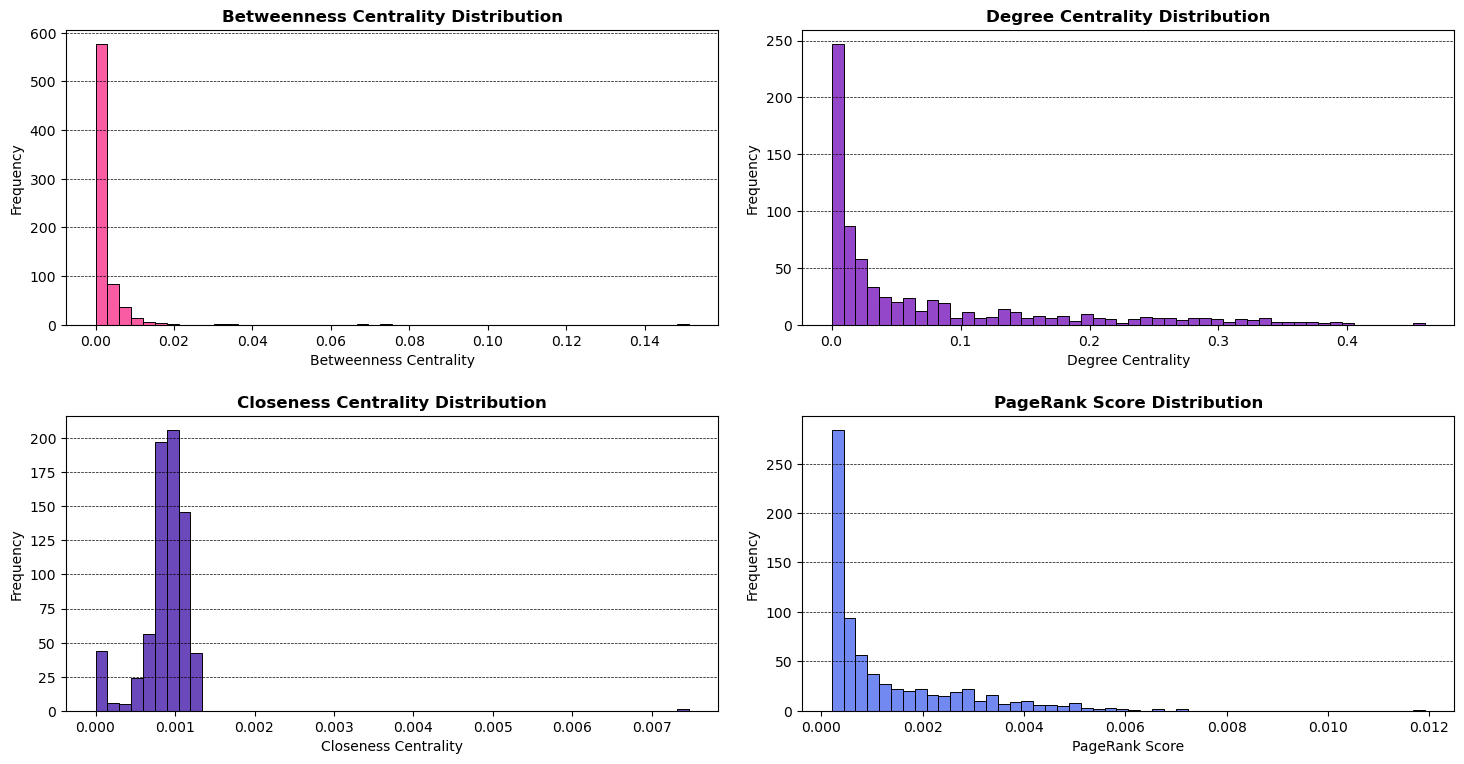

,Centrality Measure,Airport,Score
0,Betweenness,YIP,0.151216
1,Betweenness,DFW,0.074997
2,Betweenness,ELP,0.066966
3,Betweenness,MEM,0.034717
4,Betweenness,ATL,0.031947
5,Degree,YIP,0.460055
6,Degree,MSP,0.402204
7,Degree,MEM,0.395317
8,Degree,ORD,0.393939
9,Degree,ATL,0.385675


In [7]:
from Centrality_Graph import compare_centralities

results= compare_centralities(graph) # Save the top 5 scores for each measure in results variable
results # Show the results

### Consideration about the metrics distribution 

1. **Betweenness Centrality**: Extremely right-skewed with most values near 0, indicating only a tiny fraction of airports serve as major connection hubs;
2. **Degree Centrality**: Right-skewed, showing many airports with few connections (0-0.1) and progressively fewer airports with more connections (extending to 0.4). This reflects a typical hub-and-spoke structure;
3. **Closeness Centrality**: The closeness centrality distribution peaks around 0.001, indicating that most airports share a similar level of accessibility, which is relatively low compared to the rest of the network.
4. **PageRank**: Similar to the degree distribution but more concentrated at lower values (0-0.001), indicating influence is concentrated in a few major hubs.

This pattern confirms a hierarchical network with a few dominant hub airports facilitating most connections.


## <h2> 2.3 New Centrality Measure by <strong> ChatGPT 4 </strong> <img src=https://cdn.iconscout.com/icon/free/png-256/free-chatgpt-logo-icon-download-in-svg-png-gif-file-formats--chat-gpt-ai-tool-artificial-intelligence-productivity-apps-pack-logos-icons-8630392.png width=100 style="vertical-align: middle"> </h2>

 To improve the results OpenAI’s Large Language Model suggested that I try using the **Katz Centrality Measure** for this task. This takes into account not only the number of direct connections a node has, but also the influence it can exert through indirect connections, taking into account the importance of its neighbors. This is particularly useful when you want to take into account the long-range effect and overall influence of a node in a graph, which in the case of airports can be important to understand not only which airports are directly connected to each other, but also which airports have a significant impact through indirect or less obvious routes. **Katz centrality** can be useful for identifying airports that are critical not only because of the number of direct flights, but also the indirect flights that pass through them. 

 ### How can you check that the results given by the **LLM** are trustable?

The Katz centrality formula used here is a  measure for ranking nodes in networks, especially directed ones like airport networks. It considers both direct and indirect connections, weighted by a decay factor, making it effective for sparse or hierarchical structures. The approach aligns with the definition on [here](https://en.wikipedia.org/wiki/Katz_centrality), ensuring theoretical correctness and practical robustness.

To verify the solution suggested by the LLM we apply the **Katz Centrality** to the Graph of Airport Network using `GraphMetrics` class
 
The Katz centrality we implemented based by LLM suggest is defined as:


$C_K(i) = \alpha \sum_{j \in \mathcal{N}(i)} C_K(j) + \frac{1 - \alpha}{N}$

Where:
- $C_K(i)$: Katz centrality of node i.
- $alpha $ Decay factor, controlling the influence of neighbors.
- $mathcal{N}(i)$: Set of neighbors of node i (outgoing edges in a directed graph).
- $N$: Total number of nodes in the graph.
- $ \frac{1 - \alpha}{N}$: Normalization term, ensuring a baseline centrality for all nodes.

---

### Key features of this variant 

1. **Normalization**:
   - Instead of a fixed bias term $\beta$, it distributes a minimum centrality uniformly across all nodes via $\frac{1 - \alpha}{N}$.

2. **Iterative Update**:
   - The centrality of each node is iteratively updated based on the centrality of its neighbors, scaled by $\alpha$.

In [8]:
# Compute Katz to Graph and store the results in katz variable
katz = G.katz_centrality() 
# Let's create a DataFrame of Katz values ​​and 
# use the describe function to show lots of information about the range of values
pd.DataFrame({"Katz Value":list(katz.values())}).describe()

,Katz Value
count,727.000000
mean,0.023731
std,0.028522
min,0.001971
25%,0.003299
50%,0.009076
75%,0.034345
max,0.105407


## 2.4 Update Compare Centralities
Looking at this table with seems to be new information compared to the other centrality measures. Let's now proceed to compare the other metrics that we already computed.

In this section we used the `compare centralities v2` function of the **Centrality_Graph** module to compare the five centrality measures and their respective distributions using 5 histograms.

Furthermore, the function returns a DataFrame with the top 5 scores for each measure.

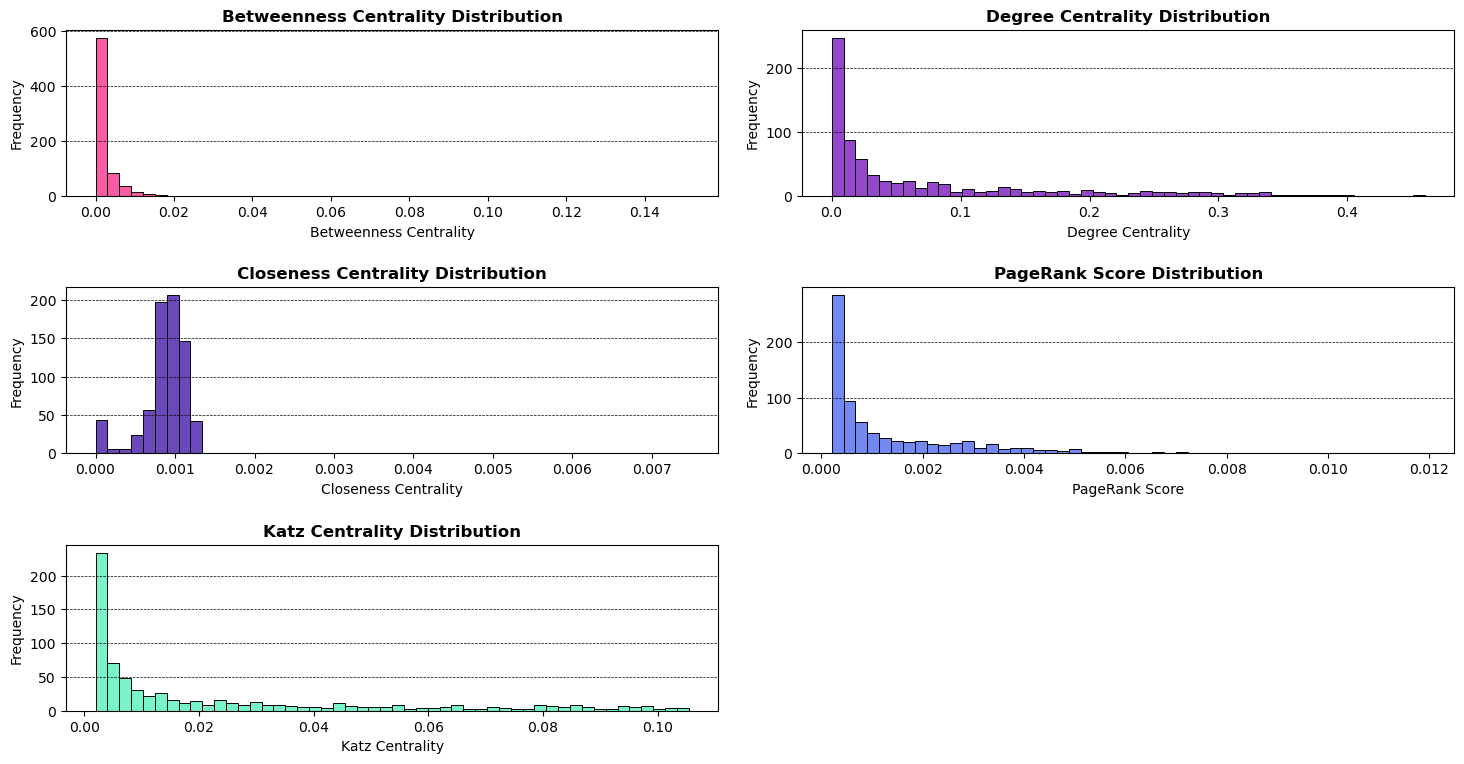

,Centrality Measure,Airport,Score
0,Betweenness,YIP,0.151216
1,Betweenness,DFW,0.074997
2,Betweenness,ELP,0.066966
3,Betweenness,MEM,0.034717
4,Betweenness,ATL,0.031947
5,Degree,YIP,0.460055
6,Degree,MSP,0.402204
7,Degree,MEM,0.395317
8,Degree,ORD,0.393939
9,Degree,ATL,0.385675


In [9]:
from Centrality_Graph import compare_centralities_v2

results_v2 = compare_centralities_v2(graph) # Save the top 5 scores for each measure in results_v2 variable
results_v2 # Show the results

 **Katz vs Other Centralities**

Most of centrality metrics show high skewness, but the Katz centrality show a smoother distribution than the sharp peaks seen in Betweenness and PageRank. Katz better distinguishes node importance than Closeness centrality, by weighting all paths, not just shortest ones. Its broader value range respect to PageRank's  distribution below 0.004 reveals important secondary hubs through indirect connections.

# 3. Finding Best Routes

Whenever you plan to fly to a specific city, your goal is to find the most efficient and fastest flight to reach your destination. In the system we are designing, the best route is defined as the one that minimizes the total distance flown to the greatest extent possible.

In this section, we  implement a function that, given an origin and destination city, determines the best possible route between them. To simplify, the focus will be limited to flights operating on a specific day.

In [4]:
# Removes the state part, leaving only the city name in the "Origin_city" and "Destination_city" columns
df[["Origin_city", "Destination_city"]] = df[["Origin_city", "Destination_city"]].apply(lambda col: col.str.split(",").str[0])

In [4]:
# Show all Origin Cities names of the DataFrame
print(df["Origin_city"].unique())

['Manhattan' 'Eugene' 'Medford' 'Seattle' 'Portland' 'Klamath Falls'
 'San Francisco' 'Los Angeles' 'Wenatchee' 'Yakima' 'Elko' 'Salem'
 'Spokane' 'Redding' 'Lewiston' 'Astoria' 'Port Angeles' 'Pendleton'
 'San Jose' 'Eureka' 'Pullman' 'Sacramento' 'Fort Lauderdale' 'Phoenix'
 'Longview' 'Great Falls' 'Fresno' 'Tucson' 'Moses Lake' 'Billings'
 'Dallas' 'Roseburg' 'Salt Lake City' 'Casper' 'Bend' 'Reno' 'Fairbanks'
 'Anchorage' 'El Paso' 'Chico' 'Santa Fe' 'Albuquerque' 'Fort Smith'
 'Las Vegas' 'Wichita' 'Duluth' 'Crescent City' 'Oklahoma City'
 'San Diego' 'Santa Rosa' 'Durango' 'Oakland' 'Houston' 'Dubuque' 'Helena'
 'Tulsa' 'Omaha' 'Waco' 'Butte' 'Austin' 'Peoria' 'Wausau' 'Pueblo'
 'Topeka' 'Colorado Springs' 'Grand Junction' 'North Platte'
 'Wichita Falls' 'Cheyenne' 'Aberdeen' 'Brainerd' 'Amarillo' 'Roswell'
 'Bismarck' 'Missoula' 'Gillette' 'Lubbock' 'Liberal' 'Midland' 'Madison'
 'Lincoln' 'Waterloo' 'Rockford' 'Green Bay' 'La Crosse' 'Kalispell'
 'Milwaukee' 'Bellingham' 'Fort

The `information_collection` function from the **AirlineRouteNetwork** module allows users to gather flight details by specifying the departure city, destination city and the flight date. 

Key features of the function:
1. **Departure City**: The user is prompted to enter the departure city. The function checks if the city exists in the airports dataset;
2. **Destination City**: After selecting the departure city, the available destination cities are displayed for the user to choose from;
3. **Flight Date**: The function displays available flight dates for the chosen route. If only one date is available, it is automatically selected; otherwise, the user is prompted to enter a date;
4. **Validation**: The function ensures that the user input is valid, handling errors like unrecognized cities or invalid dates, and provides feedback if no flights match the selected criteria.

This function is designed to provide a user-friendly interface for querying flight information.

Further information is provided below using the Python `help` function.

In [3]:
from AirlineRouteNetwork import information_collection
help(information_collection)

Help on function information_collection in module AirlineRouteNetwork:

information_collection(flights: pandas.core.frame.DataFrame)
    Filters flight information based on user input for departure city, destination city, and flight date.
    
    Args:
        flights (pd.DataFrame): A DataFrame containing flight information with columns such as 
                                'Origin_city', 'Destination_city', and 'Fly_date'.
    
    Returns:
           tuple: A tuple containing the selected origin city, destination city, and flight date (str).
    
    Raises:
        TypeError: If the departure city or destination city is not found.
        ValueError: If no flights are found for the given date.



### Function Description

Detailed description of the `find best routes` function of the **FlightNetwork** class:

---

### Inputs

---

This function takes in the following inputs:

- **Flights network**: A data structure representing the flight network. It can be a graph where the nodes are airports;
- **Origin city name**: The name of the city from which the flight starts;
- **Destination city name**: The name of the city to which the flight is headed;
- **Considered Date**: The date in `yyyy-mm-dd` format.

### Output

---

The output will be a table with three columns:

1. **Origin_city_airport**: The airport in the origin city;
2. **Destination_city_airport**: The airport in the destination city;
3. **Best_route**: A list of airport names connected by `→` showing the order in which they are to be visited during the optimal route. If no such route exists, the entry should display `No route found`.

In [6]:
# Import the class that has find best routes function 
from AirlineRouteNetwork import FlightNetwork
# More details about the class
help(FlightNetwork) 

Help on class FlightNetwork in module AirlineRouteNetwork:

class FlightNetwork(builtins.object)
 |  A class to represent and analyze a flight network, where airports are nodes and flights are directed edges 
 |  with weights corresponding to the distance between airports. The class allows adding flights, computing 
 |  shortest paths using Dijkstra's algorithm, and finding the best routes between airports for a given date.
 |  
 |  Methods:
 |  
 |  add_flight(origin, destination, distance): Adds a flight between two airports to the network.
 |  
 |  shortest_paths(start): Computes the shortest paths from a starting airport to all other airports using Dijkstra's algorithm.
 |  
 |  find_best_routes(origin_city, destination_city, date, flights): Finds the best routes between origin and 
 |  destination cities for the given date based on available flights.
 |  
 |  Functions: 
 |  
 |  information_collection(flights):
 |  
 |  Allows the user to select a departure city, destination city

### 1. Example : 

Origin City : Rome --> Destination City : Dallas

In [5]:
# Call the information_collection function to collect flight details based on user input
# It returns the selected origin city, destination city and date from the user’s choices
origin_city,destination_city,date=information_collection(df)

origin_city:  Rome
List of destination city availables: ['Dallas' 'Detroit']
Available dates:  2007-10-01
You selected the following information:
Departure City: Rome
Arrival City: Dallas
Selected Date: 2007-10-01


In [7]:
# Call the find_best_routes method to get the best flight routes between the origin and destination cities for the selected date
results=FlightNetwork().find_best_routes(origin_city,destination_city,date,df)
results # Show the table 

,Origin_city_airport,Destination_city_airport,Best_route
0,RMG,DFW,RMG → DAL → DFW
1,RMG,AFW,RMG → DAL → AUS → AFW
2,RMG,DAL,RMG → DAL
3,RMG,ADS,RMG → DAL → LRD → ADS


### 2. Example : 
Origin City : New York --> Destination City : Las Vegas

In [8]:
origin_city,destination_city,date=information_collection(df)

origin_city:  New York
List of destination city availables: ['Erie' 'Gary' 'Reno' 'Waco' 'Yuma' 'Akron' 'Dover' 'Fargo' 'Flint'
 'Macon' 'Miami' 'Ogden' 'Omaha' 'Tampa' 'Tulsa' 'Albany' 'Austin'
 'Bangor' 'Boston' 'Casper' 'Clovis' 'Dallas' 'Dayton' 'Duluth' 'Elmira'
 'Fresno' 'Helena' 'Ithaca' 'Laredo' 'Lawton' 'Marion' 'Mobile' 'Monroe'
 'Newark' 'Peoria' 'Pueblo' 'Sumter' 'Tacoma' 'Toledo' 'Topeka' 'Tucson'
 'Yakima' 'Abilene' 'Atlanta' 'Augusta' 'Beckley' 'Buffalo' 'Chicago'
 'Detroit' 'El Paso' 'Houston' 'Jackson' 'Kahului' 'Killeen' 'Kinston'
 'Lansing' 'Lincoln' 'Lubbock' 'Madison' 'Medford' 'Memphis' 'Oakland'
 'Orlando' 'Phoenix' 'Raleigh' 'Reading' 'Roanoke' 'Roswell' 'Saginaw'
 'Seattle' 'Shelton' 'Spokane' 'Trenton' 'Wichita' 'Amarillo' 'Appleton'
 'Beaumont' 'Billings' 'Bismarck' 'Cheyenne' 'Columbia' 'Columbus'
 'Gulfport' 'Hartford' 'Honolulu' 'Key West' 'Lewiston' 'Longview'
 'Meridian' 'Montrose' 'New Bern' 'New York' 'Portland' 'Richmond'
 'Rockford' 'San Jose' 'Santa

In [9]:
results=FlightNetwork().find_best_routes(origin_city,destination_city,date,df)
results

,Origin_city_airport,Destination_city_airport,Best_route
0,LGA,LAS,LGA → CLE → LAS
1,LGA,LSV,LGA → STL → ABQ → TUS → LSV
2,JFK,LAS,JFK → LAS
3,JFK,LSV,JFK → ABQ → TUS → LSV
4,JRB,LAS,JRB → EWR → LAS
5,JRB,LSV,JRB → EWR → DAY → STL → ABQ → TUS → LSV
6,TSS,LAS,TSS → EWR → LAS
7,TSS,LSV,TSS → EWR → DAY → STL → ABQ → TUS → LSV
